# Imports

In [1]:
import json 
import string
import numpy as np
import pandas as pd
import re, nltk, spacy, string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import en_core_web_sm
nlp = spacy.load("en_core_web_sm")
# stopwords = nlp.Defaults.stop_words
from spacy.lang.en.stop_words import STOP_WORDS
# stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from sklearn.decomposition import NMF
from sklearn import preprocessing
from nltk import ngrams
from nltk import FreqDist
from sklearn.decomposition import LatentDirichletAllocation as LDA
# nltk.download('all')
from nltk import pos_tag

In [2]:
# charts
import matplotlib.pyplot as plt
import seaborn as sns
import os
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [3]:
#warnings
import warnings
warnings.filterwarnings('ignore')

#options
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)

In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# Functions

### 1. Data cleaning

In [6]:
def clean_text(text):
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub('\S*\d\S*\s*','', text)
    text = re.sub('\[.*\]','', text)
    text = re.sub('xxxx','', text)
    text = re.sub('-PRON-', '', text)

    return text

def remove_stopwords(tokens):
    # Remove common English stop words
    # stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in STOP_WORDS]

    return filtered_tokens

def tokenize_text(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)

    return tokens

### 2. Merge cleaning functions to one function

In [7]:
def preprocess_text(text):
    cleaned_text = clean_text(text)
    tokens = tokenize_text(cleaned_text)
    tokens_without_stopwords = remove_stopwords(tokens)
    preprocessed_text = ' '.join(tokens_without_stopwords)
    
    return preprocessed_text


In [9]:
# # nltk download - issue with ssl certyficate

# import nltk
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download('all')

### 3. Restore basic forms of words

In [10]:
def lemmatize(text):
    doc = nlp(text)
    sent = [token.lemma_ for token in doc if token.text not in STOP_WORDS]

    return ' '.join(sent)

def stemming(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stem_words = [stemmer.stem(word) for word in tokens if word.text.lower() not in STOP_WORDS]
    
    return ' '.join(stem_words)

def remove_pos_tags(text):
    doc = nlp(text)
    sent = [token.text for token in doc if token.tag_ == 'NN']

    return ' '.join(sent)
    

# finding ngrams

In [11]:
def get_ngrams(text, n):
    tokens = word_tokenize(text)
    n_grams = ngrams(tokens, n)
    return list(n_grams)

def get_top_ngrams(data, n, top=30):
    combined_text = ' '.join(data.astype(str))
    n_grams = get_ngrams(combined_text, n)
    freq_dist = FreqDist(n_grams)
    return freq_dist.most_common(top)

# Importing data 

### dataset - https://www.kaggle.com/datasets/abhishek14398/automatic-ticket-classification-dataset/data

In [12]:
path = "complaints.json"
open_path = open(path) 
read_data = json.load(open_path)
df=pd.json_normalize(read_data)

In [13]:
df = df[['_source.complaint_what_happened','_source.product','_source.sub_product']]
df = df.rename(columns={'_source.complaint_what_happened': 'complaint_text', '_source.product': 'category','_source.sub_product': 'sub_category'})

# data modelling
df['category'] = df['category'] + '+' + df['sub_category']
df = df.drop(['sub_category'],axis= 1)

df[df['complaint_text']==''] = np.nan
df = df[~df['complaint_text'].isnull()]


# text cleaning

In [14]:

data = df # replace to have possibility to load back original data

data['text_clean'] = data['complaint_text'].apply(lambda x: preprocess_text(x))
data['text_clean'] = data['text_clean'].apply(lambda x: lemmatize(x))
data['text_clean'] = data['text_clean'].apply(lambda x: remove_pos_tags(x))


### Check data

(array([8.163e+03, 6.342e+03, 3.100e+03, 1.491e+03, 8.690e+02, 5.130e+02,
        2.080e+02, 1.080e+02, 5.400e+01, 6.500e+01, 2.900e+01, 3.200e+01,
        1.900e+01, 1.100e+01, 1.200e+01, 8.000e+00, 1.000e+01, 3.000e+00,
        5.000e+00, 7.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 2.000e+00,
        5.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([    0.  ,   210.28,   420.56,   630.84,   841.12,  1051.4 ,
         1261.68,  1471.96,  1682.24,  1892.52,  2102.8 ,  2313.08,
         2523.36,  2733.64,  2943.92,  3154.2 ,  3364.48,  3574.76,
         3785.04,  3995.32,  4205.6 ,  4415.88,  4626.16,  4836.44,
         5046.72,  5257.  ,  5467.28,  5677.56,  5887.84,  6098.12,
         6308.4 ,  6518.68,  6728.96

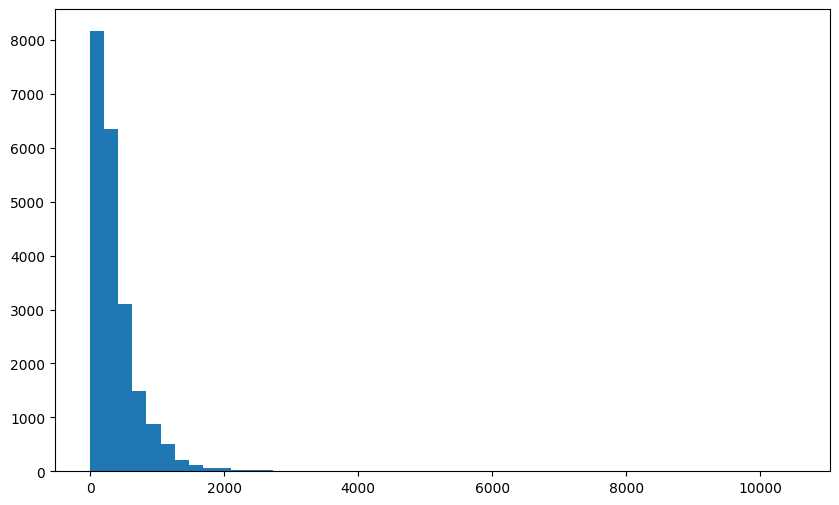

In [15]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in data['text_clean']]
plt.hist(doc_lens, bins = 50)

In [17]:
data['text_clean'] = data['text_clean'].str.lower()
data['text_clean'] = data['text_clean'].str.replace('-PRON-', '')
data['text_clean'] = data['text_clean'].str.replace('xxxx','')


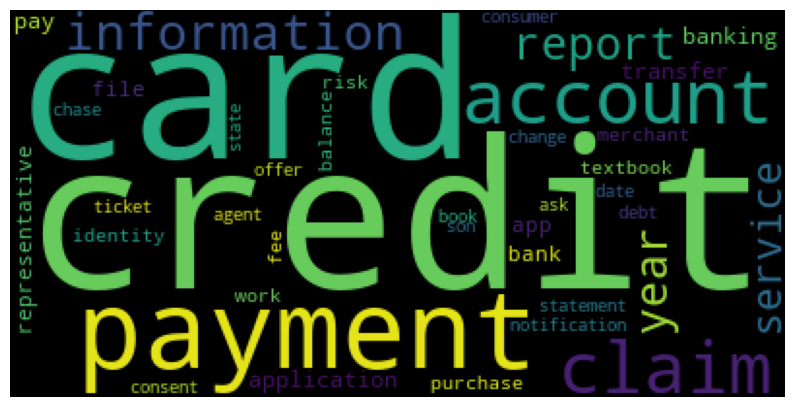

In [18]:

from wordcloud import WordCloud

# wordcloud = WordCloud(stopwords=STOP_WORDS, max_words=40).generate(str(data['text_clean']))
wordcloud = WordCloud(stopwords=STOP_WORDS, max_words=40).generate(str(data['text_clean']))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Topic Modelling
### in this dataset I have too much categories, so my plan is to change quantity of categories to 5.
### This can be done by NFM or LDA
###
###
###

### Finding top n-grams

In [19]:
top_unigrams = get_top_ngrams(data['text_clean'], 1)
top_bigrams = get_top_ngrams(data['text_clean'], 2)
top_trigrams = get_top_ngrams(data['text_clean'], 3)


print("\n top unigrams : \n", top_unigrams[:5])
print("\n top top_bigrams : \n",top_bigrams[:5])
print("\n top top_trigrams : \n",top_trigrams[:5])


 top unigrams : 
 [(('account',), 42377), (('credit',), 30687), (('card',), 27460), (('payment',), 20605), (('time',), 15264)]

 top top_bigrams : 
 [(('credit', 'card'), 11247), (('credit', 'report'), 3710), (('check', 'account'), 2803), (('customer', 'service'), 2514), (('account', 'account'), 2010)]

 top top_trigrams : 
 [(('credit', 'card', 'account'), 1017), (('credit', 'card', 'company'), 872), (('credit', 'card', 'credit'), 509), (('charge', 'credit', 'card'), 490), (('inquiry', 'credit', 'report'), 484)]


### Vectorizer

In [29]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
# dtm = model.fit_transform(data['text_clean']) # document term metrix
dtm = tfidf.fit_transform(data['text_clean'])
feature_names = np.array(tfidf.get_feature_names_out())

In [24]:
# model = CountVectorizer(min_df=2, max_df=0.95, stop_words='english')
# dtm = model.fit_transform(data['text_clean']) # document term metrix
# feature_names = np.array(model.get_feature_names_out())

### NFM

In [32]:
from sklearn.preprocessing import normalize

num_topics = 5  # You can adjust the number of topics as needed
nmf_model = NMF(n_components=num_topics, random_state=40)
# nmf_model = NMF(n_components=num_topics)
nmf_matrix = nmf_model.fit_transform(dtm)

# Normalize the NMF matrix
nmf_matrix_normalized = normalize(nmf_matrix, axis=1)

# Assign topics to documents
data['topic'] = nmf_matrix_normalized.argmax(axis=1)


for topic in range(num_topics):
    topic_words_idx = nmf_model.components_[topic].argsort()[-15:][::-1]
    topic_words = [feature_names[i] for i in topic_words_idx]
    
    print(f"Top 15 words for Topic {topic}:\n")
    print(topic_words)
    print("\n")


Top 15 words for Topic 0:

['account', 'check', 'money', 'bank', 'deposit', 'fund', 'day', 'branch', 'transfer', 'number', 'business', 'transaction', 'chase', 'customer', 'claim']


Top 15 words for Topic 1:

['credit', 'card', 'report', 'inquiry', 'account', 'score', 'company', 'information', 'chase', 'limit', 'application', 'debt', 'letter', 'year', 'balance']


Top 15 words for Topic 2:

['payment', 'balance', 'month', 'pay', 'statement', 'fee', 'time', 'day', 'mortgage', 'date', 'credit', 'year', 'auto', 'account', 'error']


Top 15 words for Topic 3:

['charge', 'card', 'dispute', 'fee', 'transaction', 'purchase', 'merchant', 'claim', 'service', 'refund', 'fraud', 'time', 'email', 'statement', 'balance']


Top 15 words for Topic 4:

['loan', 'mortgage', 'modification', 'home', 'property', 'year', 'letter', 'document', 'rate', 'request', 'time', 'foreclosure', 'refinance', 'information', 'sale']




In [33]:
data.topic.value_counts()

topic
0    5139
3    4924
1    4817
4    3818
2    2374
Name: count, dtype: int64

### LDA

In [34]:
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.preprocessing import normalize

# # Create a CountVectorizer to convert text to a matrix of token counts
# count_vectorizer = CountVectorizer(min_df=2, max_df=0.95, stop_words='english')
# dtm = count_vectorizer.fit_transform(data['text_clean'])
# feature_names = np.array(count_vectorizer.get_feature_names_out())

# # Fit an LDA model
# num_topics = 5  # You can adjust the number of topics as needed
# lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=40)
# lda_matrix = lda_model.fit_transform(dtm)

# # Normalize the LDA matrix
# lda_matrix_normalized = normalize(lda_matrix, axis=1)

# # Assign topics to documents
# data['topic'] = lda_matrix_normalized.argmax(axis=1)

# # Display top words for each topic
# for topic in range(num_topics):
#     topic_words_idx = lda_model.components_[topic].argsort()[-15:][::-1]
#     topic_words = [feature_names[i] for i in topic_words_idx]
    
#     print(f"Top 15 words for Topic {topic}:\n")
#     print(topic_words)
#     print("\n")


In [180]:
# temp =data[['complaint_text','text_clean','category', 'topic']].groupby('topic').head()
# temp.sort_values('topic')

# # data[data['topic'] == 1].head(30)


In [35]:
data['topic'].value_counts()

topic
0    5139
3    4924
1    4817
4    3818
2    2374
Name: count, dtype: int64

### MAPPING AND SAVING DF

In [36]:
# 'Reporting/information',
# 'Credit/debits Cards',
# 'Other',
# 'Banking and Account activities',
# 'Loans/Mortgages'



topic_mapping = {
    0: 'Banking and Account activities',
    1: 'Reporting/information',
    2: 'Other',
    3: 'Credit/debits Cards',
    4: 'Loans/Mortgages'
}

#Replace Topics with Topic Names
data['topic'] = data['topic'].map(topic_mapping)

data.to_csv('data.csv', index=False) # saving dataset

### VISUALISE DATA FOR EACH NEWLY CREATED TOPIC

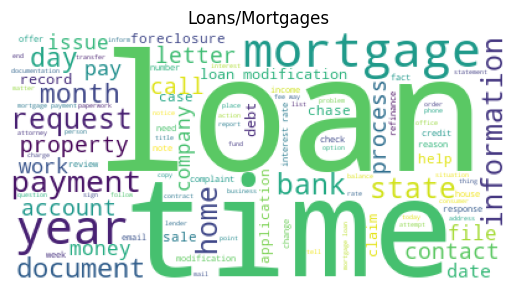

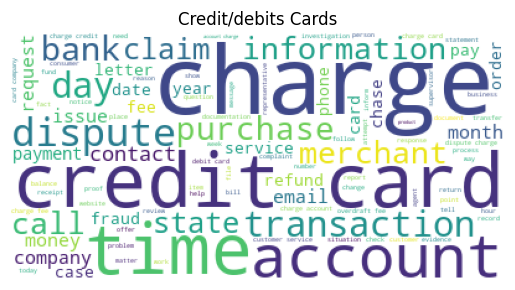

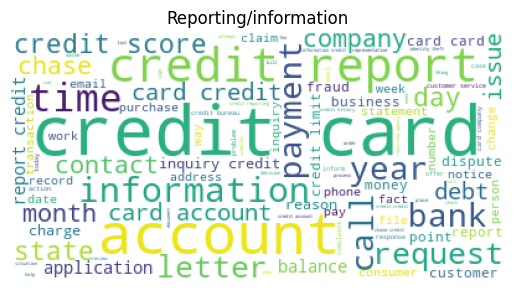

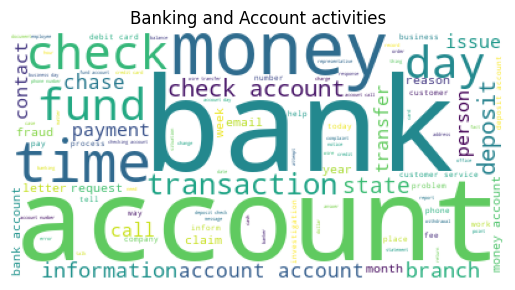

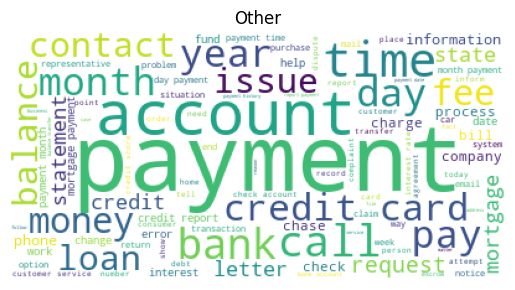

In [37]:
for x in data['topic'].unique():
	wc = WordCloud(background_color="white", max_words=100)
	# wc.generate(data['text_clean'][(data['text_clean'].notnull()) & (data['topic'] == x)].to_string())
	wc.generate(data['text_clean'][(data['text_clean'].notnull()) & (data['topic'] == x)].to_string())
	plt.imshow(wc)
	plt.title(x)
	plt.axis("off")
	plt.show()

In [38]:
data.topic.value_counts()

topic
Banking and Account activities    5139
Credit/debits Cards               4924
Reporting/information             4817
Loans/Mortgages                   3818
Other                             2374
Name: count, dtype: int64

# importing dataset

In [49]:
data = pd.read_csv('data.csv')
data.head()

,complaint_text,category,text_clean,topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Debt collection+Credit card debt,morning help cardmember service debt verification statement bank validate debt mail month attempt debt information consumer account help,Loans/Mortgages
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Credit card or prepaid card+General-purpose credit card or charge card,card agent upgrade anniversary date change agent information order account change anniversary date agent,Credit/debits Cards
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.","Credit reporting, credit repair services, or other personal consumer reports+Other personal consumer report",report application submit identity consent service credit verifying identity applicant,Reporting/information
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.","Credit reporting, credit repair services, or other personal consumer reports+Credit reporting",book ticket offer ticket reward card information minute notify screen decision bank minute notification screen representative speak application state information offer credit offer account statement purchase ticket account ask application representative application request proceed application contrary representative fact credit account report information credit report process application consent error,Reporting/information
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refu

# TESTING ON DIFFERENT CLASSIFICATORS

In [73]:
training_data = data[['text_clean','topic']]

In [56]:
# training_data['text_clean'] = training_data['text_clean'].fillna('')
# training_data[training_data['text_clean']==''] = np.nan
# training_data = training_data[~training_data['text_clean'].isnull()]

In [74]:
X = training_data['text_clean']
y = training_data['topic']

In [59]:
data['topic'].value_counts()

topic
Banking and Account activities    5139
Credit/debits Cards               4924
Reporting/information             4817
Loans/Mortgages                   3818
Other                             2374
Name: count, dtype: int64

In [75]:
cv = CountVectorizer()
X_vec = cv.fit_transform(X)

In [76]:
from sklearn.feature_extraction.text import TfidfTransformer
#Write your code here to transform the word vector to tf-idf
#Fit transform word vector to TF-IDF
tfidf_t = TfidfTransformer()
X_tfidf = tfidf_t.fit_transform(X_vec)

In [77]:
from sklearn.model_selection import train_test_split
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=40, stratify=y)

In [106]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import numpy as np

def classification(classifier, X_train, X_test, y_train, y_test):
    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)

    # Predictions on training and testing sets
    y_train_pred = classifier.predict(X_train)
    y_test_pred = classifier.predict(X_test)

    # Extract unique classes from the target variable
    unique_classes = np.unique(np.concatenate([y_train, y_test]))

    # Convert labels to binary format for ROC curve
    y_train_bin = label_binarize(y_train, classes=unique_classes)
    y_test_bin = label_binarize(y_test, classes=unique_classes)

    # Compute ROC curve and ROC area for each class
    n_classes = len(unique_classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], classifier.predict_proba(X_test)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), classifier.predict_proba(X_test).ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



      # Accuracy Scores
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Classification Report
    print("\nTraining Accuracy:", train_accuracy)
    print("\nTraining Classification Report:")
    print(classification_report(y_train, y_train_pred, target_names=unique_classes))

    print("Testing Accuracy:", test_accuracy)
    print("\nTesting Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=unique_classes))


    print("Testing Accuracy:", test_accuracy)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})', linestyle=':', linewidth=4)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve for class {unique_classes[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(unique_classes))
    plt.xticks(tick_marks, unique_classes, rotation=45)
    plt.yticks(tick_marks, unique_classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [79]:
# scaller for log reg

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression Classification


Training Accuracy: 0.9798099762470309

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.98      0.99      0.98      4094
           Credit/debits Cards       0.98      0.98      0.98      3939
               Loans/Mortgages       0.98      0.98      0.98      3054
                         Other       0.99      0.95      0.97      1899
         Reporting/information       0.98      0.98      0.98      3854

                      accuracy                           0.98     16840
                     macro avg       0.98      0.98      0.98     16840
                  weighted avg       0.98      0.98      0.98     16840

Testing Accuracy: 0.9501187648456056

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.94      0.96      0.95      1023
           Credit/debits Cards       0.95      0.95      0.95  

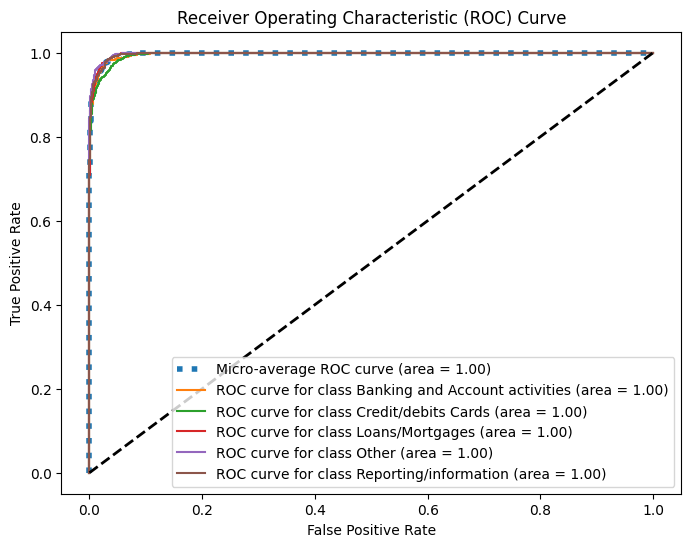

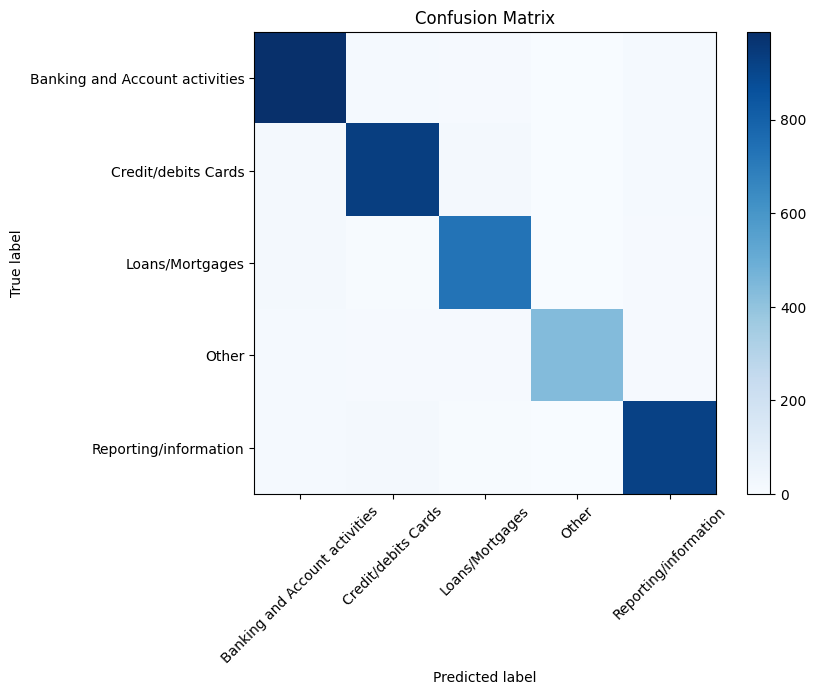

In [107]:
log_reg = LogisticRegression(random_state=40,solver='liblinear')
log_reg.fit(X_train,y_train)
classification(log_reg, X_train, X_test, y_train, y_test)

In [204]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

# FINAL TEST

In [81]:
input = 'I tried to make a transaction at a supermarket retail store, using my chase \
debit/atm card, but the transaction was declined. I am still able to withdraw money out of an \
ATM machine using the same debit card. Please resolve this issue.'

In [87]:
input_clean = preprocess_text(input)
input_clean = lemmatize(input_clean)
input_clean = remove_pos_tags(input_clean)
print("\nFinal Text:", input_clean)


Final Text: transaction supermarket store chase debitatm card transaction money machine debit card resolve issue


In [88]:
# test = cv.transform([input])
test = cv.transform([input_clean])
test_tfidf = tfidf_t.transform(test)

In [89]:
prediction=log_reg.predict(test_tfidf)
prediction

array(['Credit/debits Cards'], dtype=object)